# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Fashion MNIST

In [2]:
train_df = pd.read_csv('./datasets/fashion-mnist_train.csv')
test_df = pd.read_csv('./datasets/fashion-mnist_test.csv')

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_data = np.asarray(train_df,dtype=np.int32)
test_data = np.asarray(test_df,dtype=np.int32)
x_train = train_data[:,1:]
y_train = train_data[:,0]
x_test = test_data[:,1:]
y_test = test_data[:,0]

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=.25,random_state=42)

In [6]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
def plot_clothes(data, category=""):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    if category != "":
        plt.title(class_names[int(category)])
    plt.axis("off")

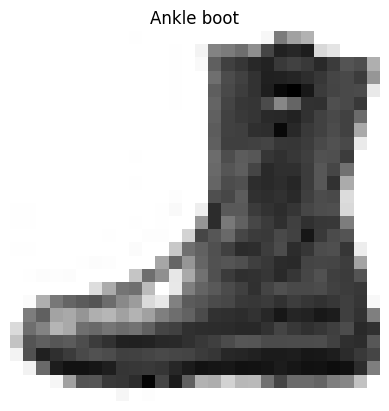

In [8]:
plot_clothes(x_train[1], y_train[1])

In [9]:
def plot_many_clothes(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_clothes_plot


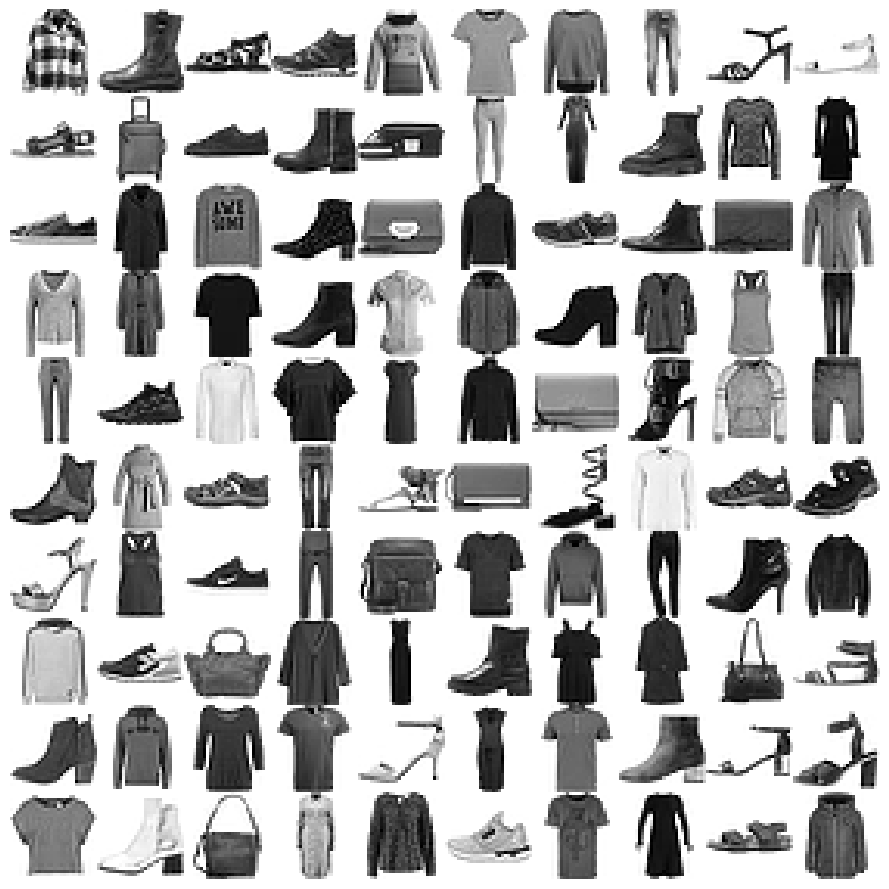

In [10]:
plt.figure(figsize=(9,9))
example_images = x_train[:100]
plot_many_clothes(example_images, images_per_row=10)
save_fig("more_clothes_plot")
plt.show()

In [11]:
y_train = y_train.astype(np.uint8)

In [12]:
y_train

array([4, 9, 5, ..., 9, 4, 0], dtype=uint8)

# Training a Binary Classifier

In [13]:
y_train_trouser = (y_train == 1)
y_test_trouser = (y_test == 1)

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(x_train, y_train_trouser)

SGDClassifier(random_state=42)

In [15]:
some_clothes = x_train[7]
sgd_clf.predict([some_clothes])

array([ True])

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_trouser, cv=3, scoring="accuracy")

array([0.98893333, 0.98093333, 0.9892    ])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(x_train, y_train_trouser):
    clone_clf = clone(sgd_clf)
    X_train_folds = x_train[train_index]
    y_train_folds = y_train_trouser[train_index]
    X_test_fold = x_train[test_index]
    y_test_fold = y_train_trouser[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9892666666666666
0.992
0.9892666666666666


In [18]:
from sklearn.base import BaseEstimator
class NeverTrouserClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_trouser_clf = NeverTrouserClassifier()
cross_val_score(never_trouser_clf, x_train, y_train_trouser, cv=3, scoring="accuracy")

array([0.90026667, 0.89673333, 0.9016    ])

## Confusion Matrix

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_trouser, cv=3)

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_trouser, y_train_pred)

array([[40020,   459],
       [  155,  4366]], dtype=int64)

In [22]:
y_train_perfect_predictions = y_train_trouser  # pretend we reached perfection
confusion_matrix(y_train_trouser, y_train_perfect_predictions)

array([[40479,     0],
       [    0,  4521]], dtype=int64)

## Precision and Recall

In [23]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_trouser, y_train_pred)

0.9048704663212436

In [24]:
cm = confusion_matrix(y_train_trouser, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.9048704663212436

In [25]:
recall_score(y_train_trouser, y_train_pred)

0.9657155496571554

In [26]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.9657155496571554

In [27]:
from sklearn.metrics import f1_score

f1_score(y_train_trouser, y_train_pred)

0.934303445324203

In [28]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.9343034453242028

## Precision/Recall Trade-off

In [29]:
y_scores = sgd_clf.decision_function([some_clothes])
y_scores

array([35501.91236856])

In [30]:
threshold = 0
y_some_clothes_pred = (y_scores > threshold)

In [31]:
y_some_clothes_pred

array([ True])

In [32]:
threshold = 10000
y_some_clothes_pred = (y_scores > threshold)
y_some_clothes_pred

array([ True])

In [33]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_trouser, cv=3,
                             method="decision_function")

In [34]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_trouser, y_scores)

Saving figure precision_recall_vs_threshold_plot


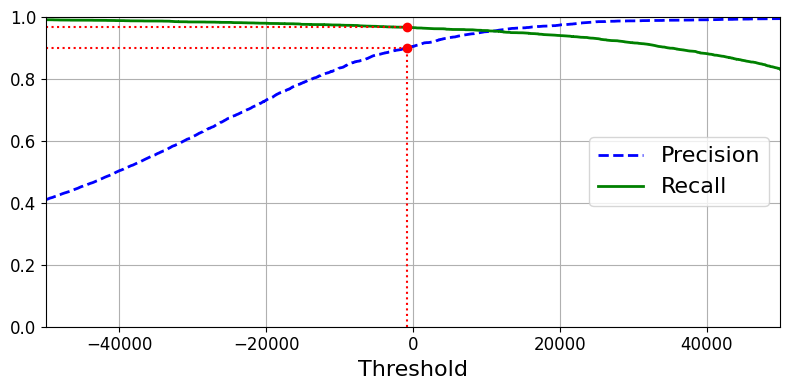

In [35]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [36]:
(y_train_pred == (y_scores > 0)).all()

True

Saving figure precision_vs_recall_plot


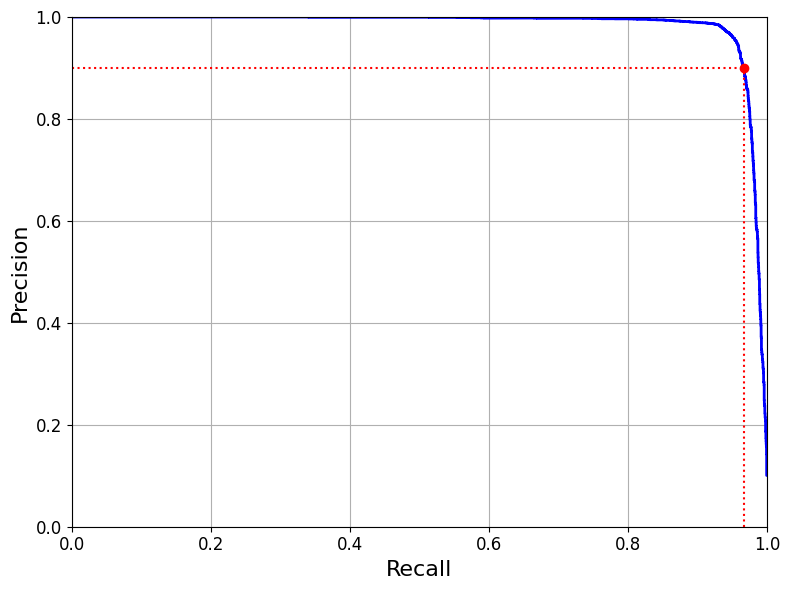

In [37]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [38]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [39]:
threshold_90_precision

-859.171703135149

In [40]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [41]:
precision_score(y_train_trouser, y_train_pred_90)

0.9001029866117405

In [42]:
recall_score(y_train_trouser, y_train_pred_90)

0.9666003096660031

## The ROC Curve

In [43]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_trouser, y_scores)

Saving figure roc_curve_plot


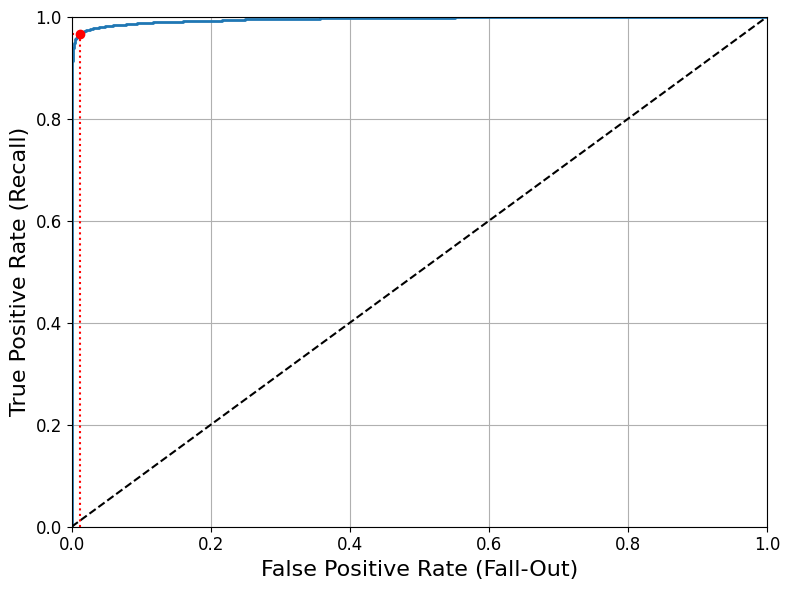

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [45]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_trouser, y_scores)

0.9954324775456684

In [46]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_trouser, cv=3,
                                    method="predict_proba")

In [47]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_trouser,y_scores_forest)

Saving figure roc_curve_comparison_plot


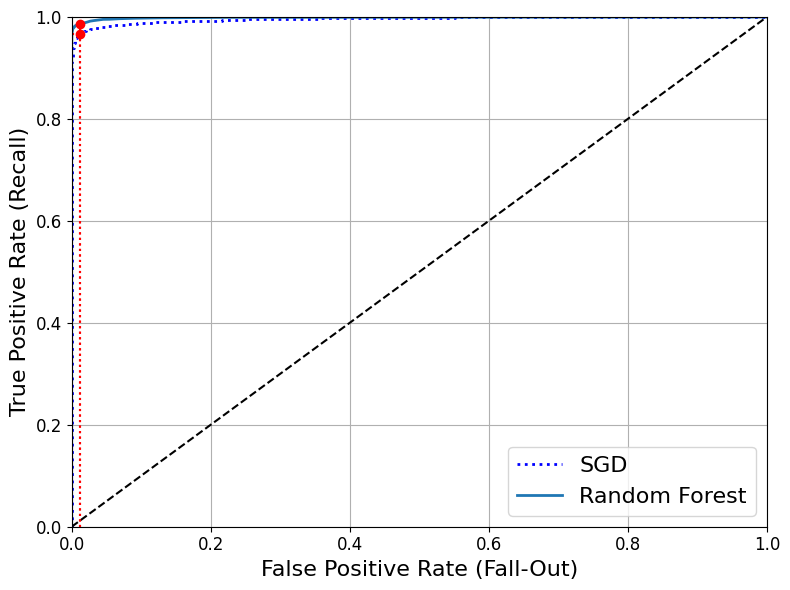

In [48]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [49]:
roc_auc_score(y_train_trouser, y_scores_forest)

0.998889765966071

In [50]:
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train_trouser, cv=3)
precision_score(y_train_trouser, y_train_pred_forest)

0.9983743613562471

In [51]:
recall_score(y_train_trouser, y_train_pred_forest)

0.9508958195089582

# Multiclass Classification

In [52]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(x_train[:1000], y_train[:1000]) # y_train, not y_train_trouser
svm_clf.predict([some_clothes])

array([1], dtype=uint8)

In [53]:
some_clothes_scores = svm_clf.decision_function([some_clothes])
some_clothes_scores

array([[ 0.7712041 ,  9.2999895 ,  7.95516039, -0.23446107,  2.82995637,
         4.87190963,  1.82995637,  3.83708759,  6.95516039,  5.89447206]])

In [54]:
np.argmax(some_clothes_scores)

1

In [55]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [56]:
svm_clf.classes_[5]

5

In [57]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(x_train[:1000], y_train[:1000])
ovr_clf.predict([some_clothes])

array([1], dtype=uint8)

In [58]:
len(ovr_clf.estimators_)

10

In [59]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_clothes])

array([1], dtype=uint8)

In [60]:
sgd_clf.decision_function([some_clothes])

array([[ -31764.07125876,   18608.16894553,  -13020.86689108,
          -4159.15171881,   -4099.83055496, -131506.45130894,
         -13646.62234262, -124879.29448656,  -29352.76687174,
         -85908.41359746]])

In [61]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.78926667, 0.81526667, 0.80566667])

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

C:\Users\balanton\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\balanton\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\balanton\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.833     , 0.82933333, 0.8338    ])

# Error Analysis

In [63]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\balanton\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\balanton\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\balanton\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([[3517,   16,   85,  318,   21,    0,  453,    0,   71,    0],
       [  12, 4274,   34,  155,   19,    0,   23,    0,    4,    0],
       [  30,    6, 3260,   76,  584,    0,  504,    0,   46,    0],
       [ 183,   58,   59, 3831,  157,    0,  162,    0,    9,    0],
       [   5,    4,  474,  262, 3314,    0,  441,    0,   17,    0],
       [   1,    1,    3,    7,    0, 4191,   12,  200,   53,   97],
       [ 588,   12,  502,  283,  389,    0, 2524,    1,  140,    0],
       [   0,    0,    0,    0,    0,  186,    0, 4051,   17,  205],
       [  19,    4,   17,   95,   27,    6,  102,   26, 4252,    5],
       [   0,    0,    0,    2,    1,   82,    5,  178,    4, 4228]],
      dtype=int64)

In [64]:
# since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


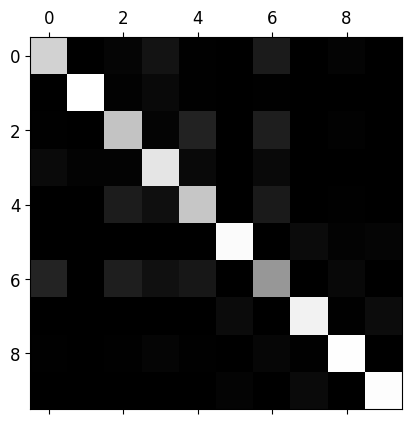

In [65]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [66]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


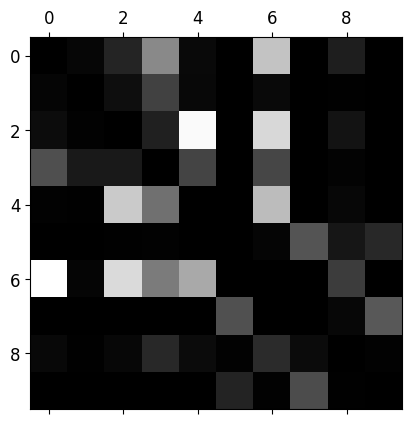

In [67]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_clothes_plot


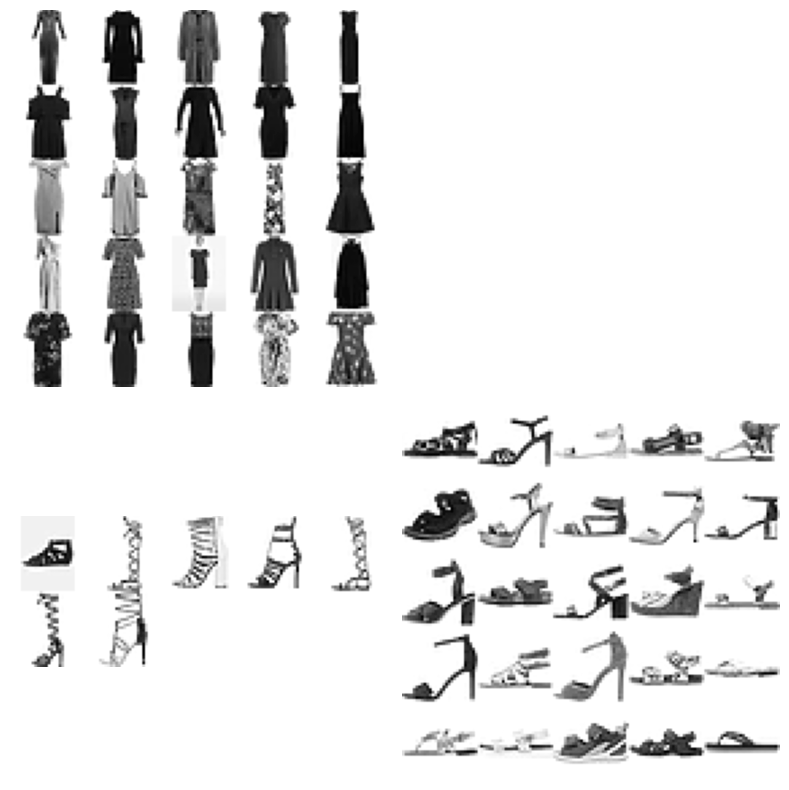

In [68]:
cl_a, cl_b = 3, 5
X_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221)
if len(X_aa) > 0:
    plot_many_clothes(X_aa[:25], images_per_row=5)
if len(X_ab) > 0:
    plt.subplot(222); plot_many_clothes(X_ab[:25], images_per_row=5)
if len(X_ba) > 0:
    plt.subplot(223); plot_many_clothes(X_ba[:25], images_per_row=5)
if len(X_bb) > 0:
    plt.subplot(224); plot_many_clothes(X_bb[:25], images_per_row=5)
save_fig("error_analysis_clothes_plot")
plt.show()

# Multilabel Classification

In [69]:
from sklearn.neighbors import KNeighborsClassifier

y_train_shoes = (y_train == 5) | (y_train == 7) | (y_train == 9)
y_train_tops = (y_train == 0) | (y_train == 2) | (y_train == 4) | (y_train == 6)
y_multilabel = np.c_[y_train_shoes, y_train_tops]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier()

In [70]:
knn_clf.predict([some_clothes])

array([[False, False]])

In [71]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9792744794454784

# Multioutput Classification

In [72]:
noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
X_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

Saving figure noisy_clothes_example_plot


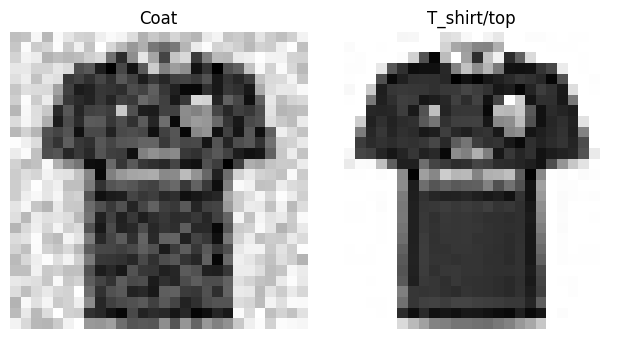

In [73]:
some_index = 0
plt.subplot(121); plot_clothes(X_test_mod[some_index], y_test[some_index])
plt.subplot(122); plot_clothes(y_test_mod[some_index], y_test[some_index])
save_fig("noisy_clothes_example_plot")
plt.show()

Saving figure cleaned_clothes_example_plot


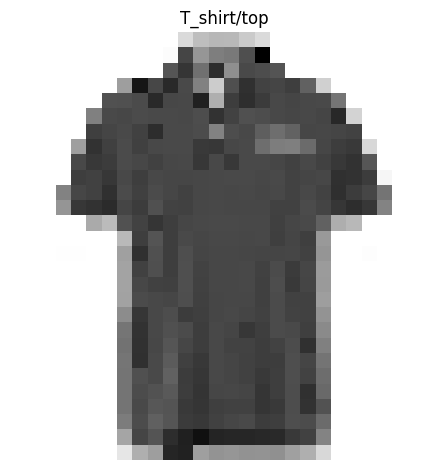

In [74]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_clothes = knn_clf.predict([X_test_mod[some_index]])
plot_clothes(clean_clothes, y_test[some_index])
save_fig("cleaned_clothes_example_plot")

# Extra material

## Dummy (ie. random) classifier

In [75]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier(strategy="prior")
y_probas_dmy = cross_val_predict(dmy_clf, x_train, y_train_trouser, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

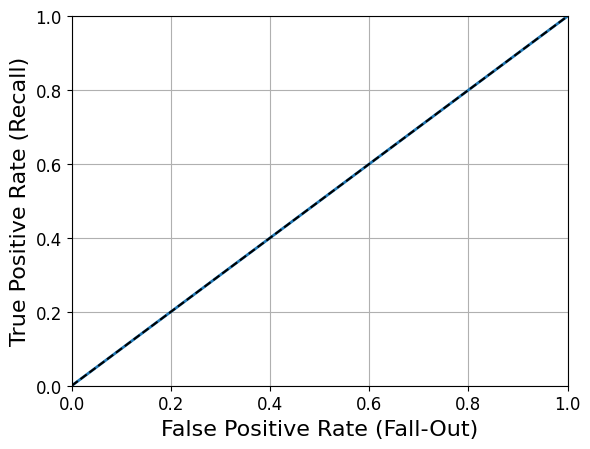

In [76]:
fprr, tprr, thresholdsr = roc_curve(y_train_trouser, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN classifier

In [77]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [78]:
y_knn_pred = knn_clf.predict(x_test)

In [79]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.8571

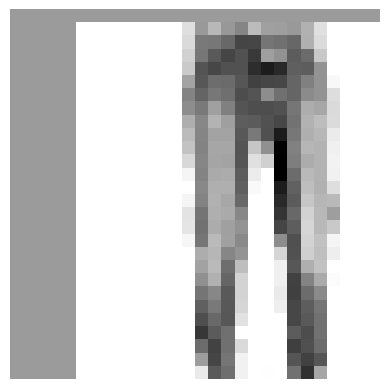

In [80]:
from scipy.ndimage import shift
def shift_clothes(clothes_array, dx, dy, new=0):
    return shift(clothes_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_clothes(shift_clothes(some_clothes, 5, 1, new=100))

In [81]:
x_train_expanded = [x_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_clothes, axis=1, arr=x_train, dx=dx, dy=dy)
    x_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

x_train_expanded = np.concatenate(x_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
x_train_expanded.shape, y_train_expanded.shape

((225000, 784), (225000,))

In [82]:
knn_clf.fit(x_train_expanded, y_train_expanded)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [83]:
y_knn_expanded_pred = knn_clf.predict(x_test)

In [84]:
accuracy_score(y_test, y_knn_expanded_pred)

0.8649

In [85]:
ambiguous_clothes = x_test[2589]
knn_clf.predict_proba([ambiguous_clothes])

array([[0.        , 0.        , 0.26287312, 0.        , 0.49975963,
        0.        , 0.23736725, 0.        , 0.        , 0.        ]])

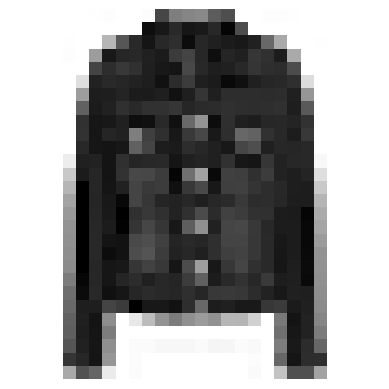

In [86]:
plot_clothes(ambiguous_clothes)